##### Importing the libraries 

In [104]:

# Standard Python libs
import warnings
import typing

# Data science libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from ydata_profiling import ProfileReport


# Use the warnings filter context manager to ignore specific warnings
with warnings.catch_warnings():
    # Filter out Pandas warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Data Understanding

### 1.1 Load dataset as DataFrame to view data

In [105]:
df = pd.read_csv("loan.csv")
df.head(10)

/Users/geotech/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
6,1069639,1304742,7000,7000,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
7,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
8,1071795,1306957,5600,5600,5600.0,60 months,21.28%,152.39,F,F2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
9,1071570,1306721,5375,5375,5350.0,60 months,12.69%,121.45,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [106]:
df['dti']

0        27.65
1         1.00
2         8.72
3        20.00
4        17.94
         ...  
39712    11.33
39713     6.40
39714     2.30
39715     3.72
39716    14.29
Name: dti, Length: 39717, dtype: float64

### 1.2 Profiling Whole Dataframe with ProfileReport

In [107]:
profile = ProfileReport(
    df, title="Profiling Report for Loan dataset",
    dark_mode=True
)
profile.to_file("profiling_result.html")

print("====== Open file profiling_result.html on the browser to view profiling result")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/geotech/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/sr/y9ng7km55ds5p79vxk5n2kw40000gn/T/ipykernel_16931/1091286961.py", line 5, in <module>
    profile.to_file("profiling_result.html")
  File "/opt/homebrew/lib/python3.11/site-packages/typeguard/__init__.py", line 1033, in wrapper
    retval = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/ydata_profiling/profile_report.py", line 355, in to_file
    data = self.to_html()
           ^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/typeguard/__init__.py", line 1033, in wrapper
    retval = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/ydata_profiling/profile_report.py", line 470, in to_html
    return self.html
        

### 1.3 Indentify Data Quality Issue

- Invalid Values
    - Unicode
    - Incorrect Data Type
    - Accepted Values
    - Format structure
    - Internal rules (sanity check)

- 

### 1.4 Interpreted The Meaning of Fields

## 2. Data Cleaning and Manipulation

### 2.1 Address Data Quality Issue

- Fix columns
    - Add columns name of missing
    - Rename columns consistently
    - Delete unnessesary columns
    - Split columns for more data
    - Merge columns for identifier
    - Align missalign columns

- Fix rows
    - Delete incorrect rows
    - Delete summary rows
    - Delete extra rows

- Fix missing values
    - Set values as missing (treat blank strings, "NA", "XX", "999", etc. as missing.)
    - Fill missing values with 
        - Constant (e.g zero)
        - Default values
        - Statistic value (e.g mode, mean, median, mix, max,....)
        - External data
    - Fill partial missing values using business judgement

- Filter data
    - Deduplicate Data by unique fields
    - Filter rows by segments, date periods
    - Filter columns pick relevant columns to analysis
    - Aggregate data

- Stadardize data
    - Remove extra characters
    - Standardize case (e.g UPPERCASE or lowercase)
    - Standardize format


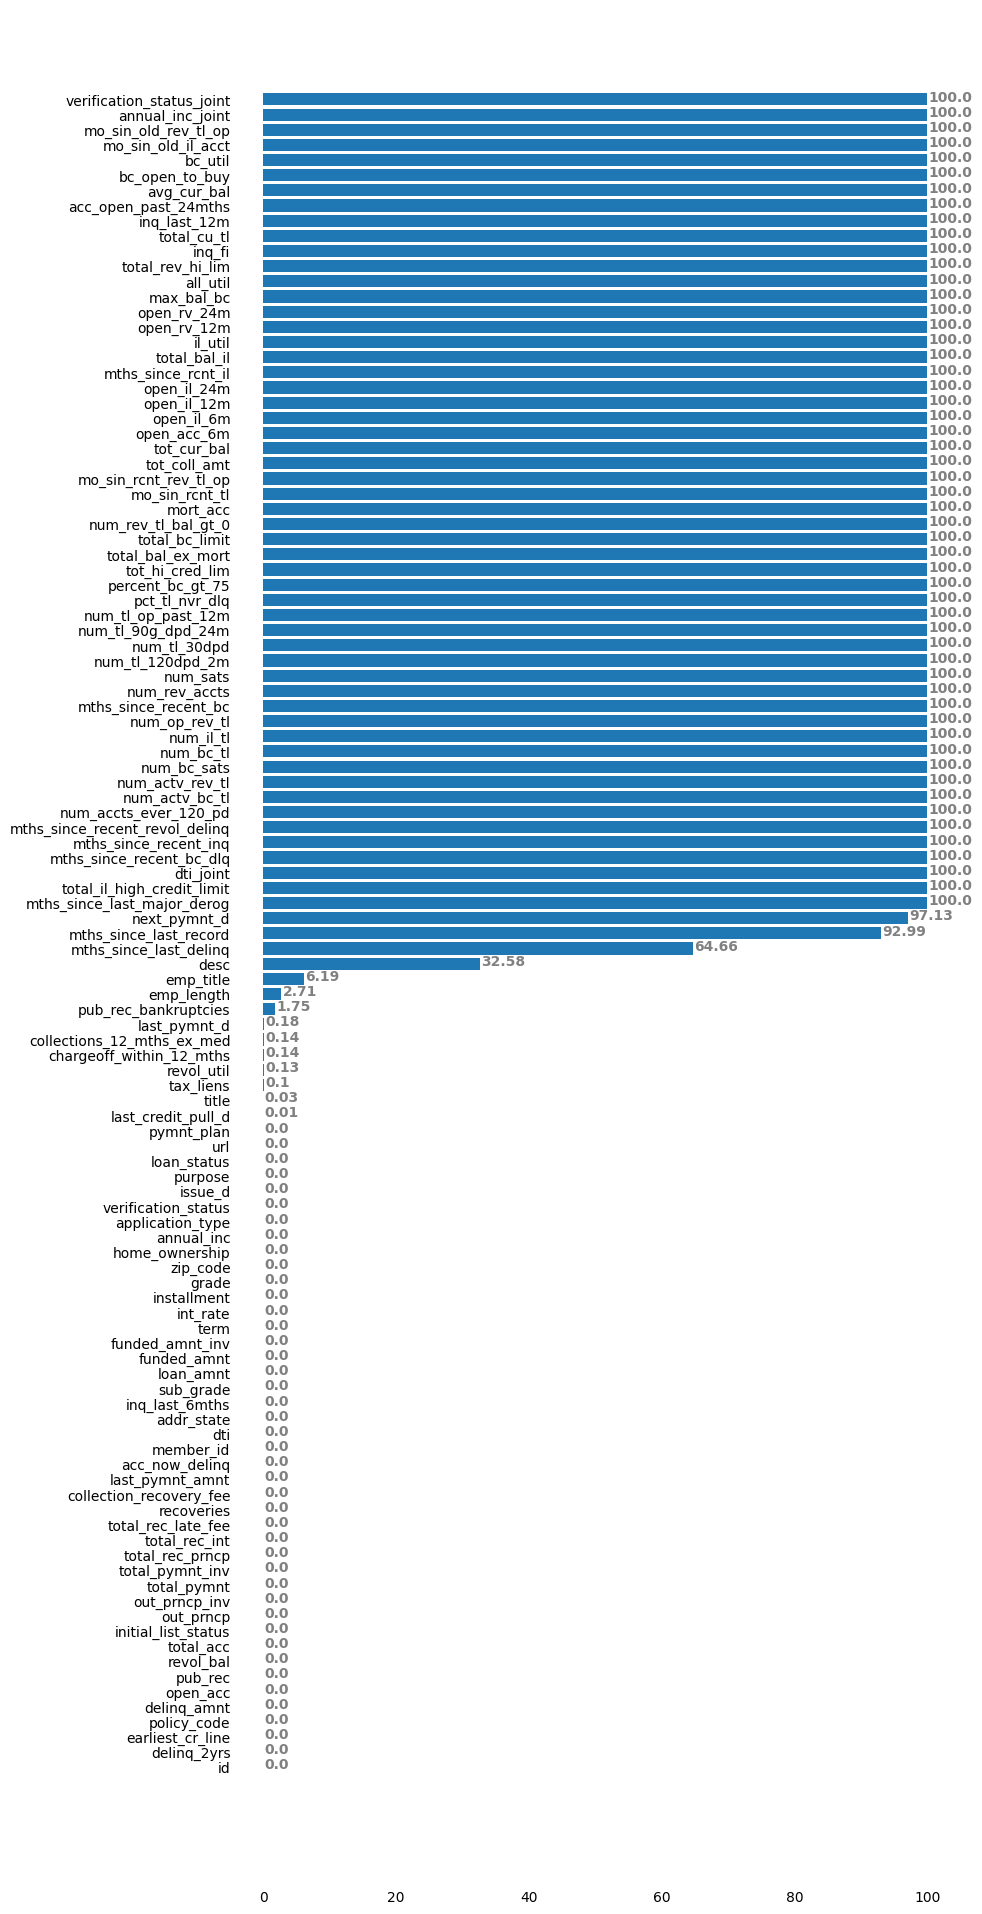

In [109]:
# We measure percentage missing value in per field and introduce a new dataframe to monitor
missing_df = df.isnull().sum() * 100 / len(df)
missing_df.to_frame(name="percent_missing")

missing_df = missing_df.reset_index()
missing_df.columns = ['field', 'percent_missing']
missing_df = missing_df.sort_values(by="percent_missing", ascending=False)

# Figure Size
fig, ax = plt.subplots(figsize =(9, 24))
 
# Horizontal Bar Plot
ax.barh(missing_df["field"], missing_df["percent_missing"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

In [110]:
# We wil remove all field missing value is 100%
df = df.drop(columns=missing_df[missing_df["percent_missing"] == 100]["field"].to_list())
df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,Jun-16,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,NaN,Jan-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
6,1069639,1304742,7000,7000,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
7,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,Dec-14,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
8,1071795,1306957,5600,5600,5600.0,60 months,21.28%,152.39,F,F2,...,NaN,Aug-12,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
9,1071570,1306721,5375,5375,5350.0,60 months,12.69%,121.45,B,B5,...,NaN,Mar-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


#### There are the rest of 15 missing fields
- next_pymnt_d ~= 97%
- mths_since_last_record ~= 93%
- mths_since_last_delinq ~= 67%
- desc ~= 33%
- emp_title ~= 6%
- emp_length ~= 3%
- pub_rec_bankruptcies ~= 2%
- last_pymnt_d ~= 0.1%
- chargeoff_within_12_mths ~= 0.1%
- collections_12_mths_ex_med ~= 0.1%
- revol_util ~= 0.1%
- tax_liens ~= 0.1%
- title ~= 0.1%
- last_credit_pull_d ~= 0.1%


#### Clean field "next_pymnt_d"
- Describe field: Next scheduled payment date
- Cleaning strategies:

In [ ]:
df["next_pymnt_d"]

0           NaN
1           NaN
2           NaN
3           NaN
4        Jun-16
          ...  
39712       NaN
39713       NaN
39714       NaN
39715       NaN
39716       NaN
Name: next_pymnt_d, Length: 39717, dtype: object

### Clean field "mths_since_last_record"
- Describe field: The number of months since the last public record.

In [ ]:
df["mths_since_last_record"].isna()

0         True
1         True
2         True
3         True
4         True
         ...  
39712    False
39713    False
39714    False
39715    False
39716    False
Name: mths_since_last_record, Length: 39717, dtype: bool

#### Clean field "mths_since_last_delinq"
- Describe field:  The number of months since the borrower's last delinquency.

In [ ]:
df["mths_since_last_delinq"].head()

0     NaN
1     NaN
2     NaN
3    35.0
4    38.0
Name: mths_since_last_delinq, dtype: float64

#### Clean field "desc"
- Describe field: Loan description provided by the borrower

In [ ]:
df["desc"].head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

#### Clean field "emp_title"
- Describe field: The job title supplied by the Borrower when applying for the loan.*

In [ ]:
df["emp_title"].head(10)

0                          NaN
1                        Ryder
2                          NaN
3          AIR RESOURCES BOARD
4     University Medical Group
5         Veolia Transportaton
6    Southern Star Photography
7              MKC Accounting 
8                          NaN
9                    Starbucks
Name: emp_title, dtype: object

#### Clean field "emp_length"
- Describe field: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

In [ ]:
df["emp_length"].head(10)

0    10+ years
1     < 1 year
2    10+ years
3    10+ years
4       1 year
5      3 years
6      8 years
7      9 years
8      4 years
9     < 1 year
Name: emp_length, dtype: object

#### Clean field "pub_rec_bankruptcies" [IMPORTANT]
- Describe field: Number of public record bankruptcies

In [ ]:
df["pub_rec_bankruptcies"].head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: pub_rec_bankruptcies, dtype: float64

#### Clean field "last_pymnt_d"
- Describe field: Last month payment was received

In [ ]:
df["last_pymnt_d"].head(10)

0    Jan-15
1    Apr-13
2    Jun-14
3    Jan-15
4    May-16
5    Jan-15
6    May-16
7    Jan-15
8    Apr-12
9    Nov-12
Name: last_pymnt_d, dtype: object

#### Clean field "chargeoff_within_12_mths"
- Describe field: Number of charge-offs within 12 months

In [ ]:
df["chargeoff_within_12_mths"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
39712    NaN
39713    NaN
39714    NaN
39715    NaN
39716    NaN
Name: chargeoff_within_12_mths, Length: 39717, dtype: float64

#### Clean field "collections_12_mths_ex_med"
- Describe field: Number of collections in 12 months excluding medical collections

In [ ]:
df["collections_12_mths_ex_med"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
39712    NaN
39713    NaN
39714    NaN
39715    NaN
39716    NaN
Name: collections_12_mths_ex_med, Length: 39717, dtype: float64

#### Clean field "revol_util"
- Describe field: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [ ]:
df["revol_util"]

0        83.70%
1         9.40%
2        98.50%
3           21%
4        53.90%
          ...  
39712    13.10%
39713    26.90%
39714    19.40%
39715     0.70%
39716    51.50%
Name: revol_util, Length: 39717, dtype: object

#### Clean field "tax_liens"
- Describe field: Number of tax liens
- Fill 0

In [ ]:
df["tax_liens"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
39712    NaN
39713    NaN
39714    NaN
39715    NaN
39716    NaN
Name: tax_liens, Length: 39717, dtype: float64

#### Clean field "title"
- Describe field: The loan title provided by the borrower

In [ ]:
df["title"]

0                         Computer
1                             bike
2             real estate business
3                         personel
4                         Personal
                   ...            
39712             Home Improvement
39713    Retiring credit card debt
39714       MBA Loan Consolidation
39715                     JAL Loan
39716           Consolidation Loan
Name: title, Length: 39717, dtype: object

#### Clean field "last_credit_pull_d"
- Describe field: The most recent month LC pulled credit for this loan

In [ ]:
df["last_credit_pull_d"]

0        May-16
1        Sep-13
2        May-16
3        Apr-16
4        May-16
          ...  
39712    Jun-10
39713    Jul-10
39714    Jun-07
39715    Jun-07
39716    Jun-10
Name: last_credit_pull_d, Length: 39717, dtype: object

### 2.2 Address Constant Field

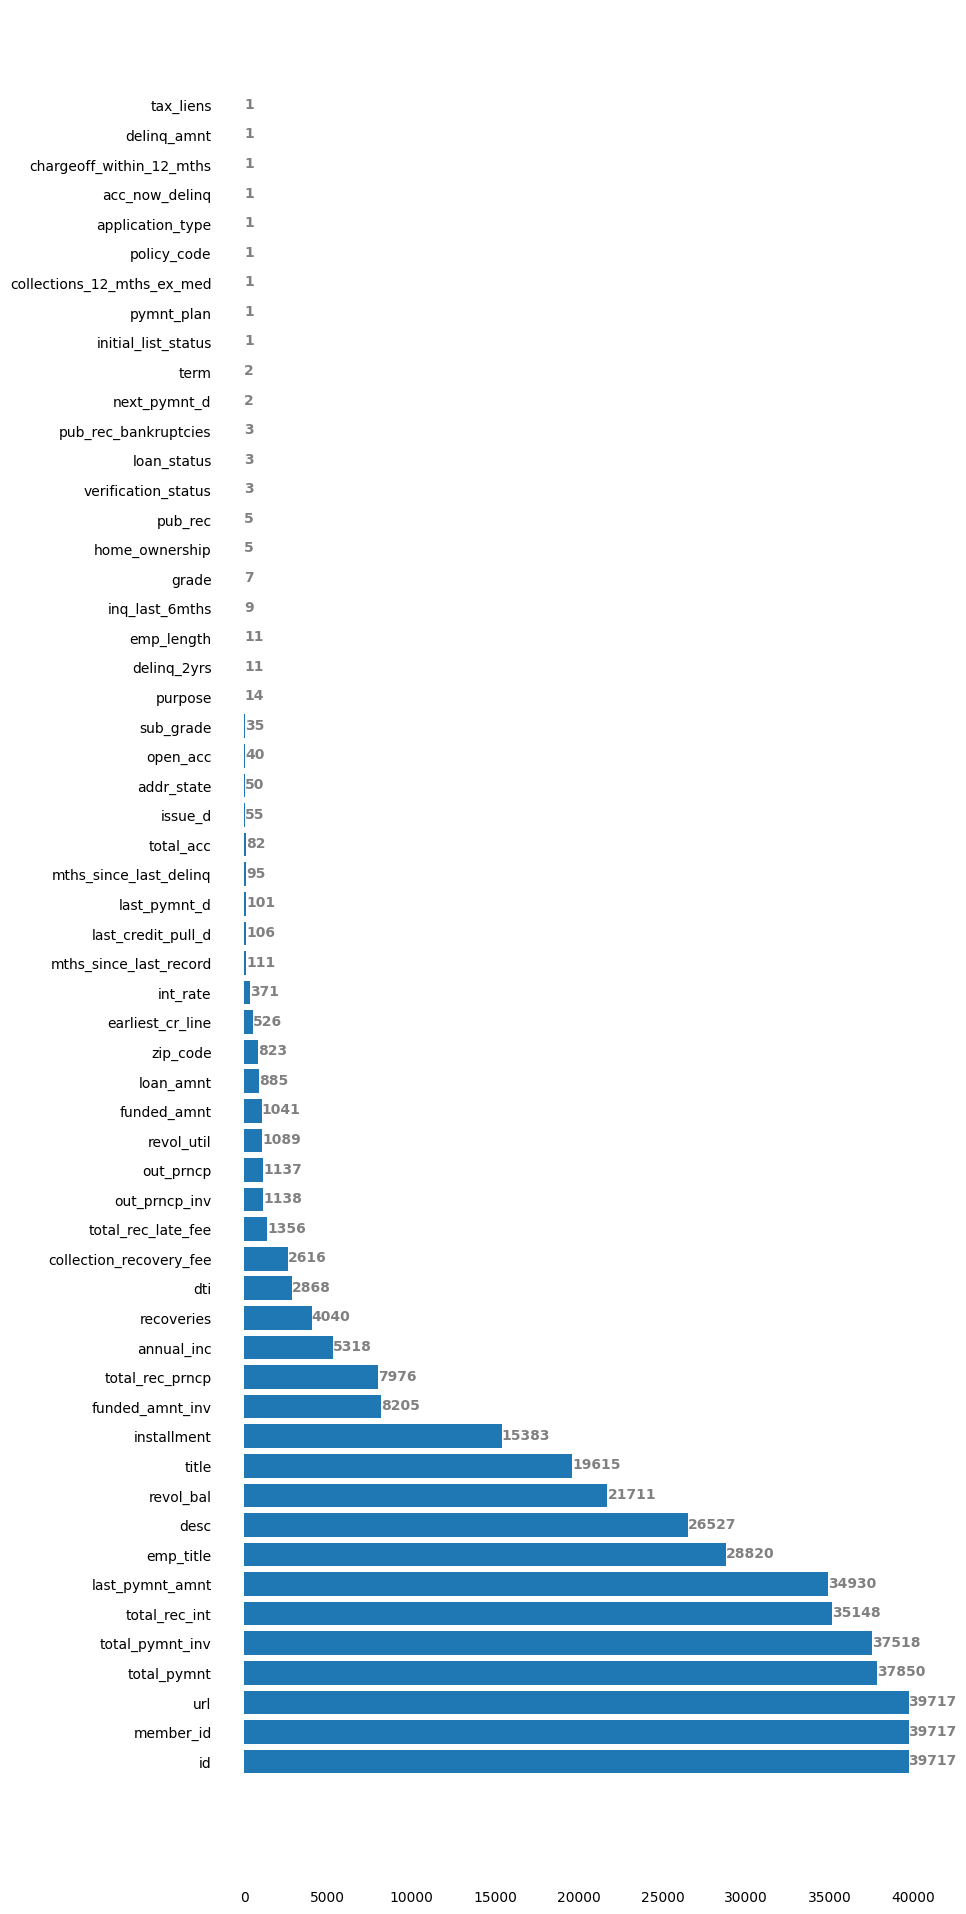

In [111]:
constant_df = df.nunique().to_frame(name='unique_value')
constant_df = constant_df.reset_index()
constant_df = constant_df.rename(columns={'index': 'field'}).sort_values(by='unique_value', ascending=True)

# Figure Size
fig, ax = plt.subplots(figsize =(9, 24))
 
# Horizontal Bar Plot
ax.barh(constant_df["field"], constant_df["unique_value"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

### Drop Constant Field Because No Statistic Meaning

In [112]:
df = df.drop(columns=constant_df[constant_df["unique_value"] == 1]["field"].to_list())
df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,Jun-16,May-16,0.0
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,5000.00,632.21,0.00,0.00,0.00,Jan-15,161.03,NaN,Jan-16,0.0
6,1069639,1304742,7000,7000,7000.0,60 months,15.96%,170.08,C,C5,...,6985.61,3125.23,0.00,0.00,0.00,May-16,1313.76,NaN,May-16,0.0
7,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,E,E1,...,3000.00,939.14,0.00,0.00,0.00,Jan-15,111.34,NaN,Dec-14,0.0
8,1071795,1306957,5600,5600,5600.0,60 months,21.28%,152.39,F,F2,...,162.02,294.94,0.00,189.06,2.09,Apr-12,152.39,NaN,Aug-12,0.0
9,1071570,1306721,5375,5375,5350.0,60 months,12.69%,121.45,B,B5,...,673.48,533.42,0.00,269.29,2.52,Nov-12,121.45,NaN,Mar-13,0.0


### 2.3 Address 100% Unique Field

In [125]:
unique_df = df.nunique() == len(df)
unique_df = unique_df.to_frame(name='is_unique_field')
unique_df = unique_df.reset_index()
unique_df = unique_df.rename(columns={'index': 'field'}).sort_values(by='is_unique_field', ascending=False)
unique_df.head(10)


,field,is_unique_field
0,id,True
17,url,True
1,member_id,True
45,next_pymnt_d,False
44,last_pymnt_amnt,False
26,inq_last_6mths,False
27,mths_since_last_delinq,False
28,mths_since_last_record,False
29,open_acc,False
30,pub_rec,False


### Drop Uniue Field To Avoid Mistake in Segmentation

In [126]:
df = df.drop(columns=unique_df[unique_df["is_unique_field"] == True]["field"].to_list())

df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,10+ years,...,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0
1,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,< 1 year,...,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0
2,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,10+ years,...,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0
3,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0
4,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,University Medical Group,1 year,...,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,Jun-16,May-16,0.0
5,5000,5000,5000.0,36 months,0.0790,156.46,A,A4,Veolia Transportaton,3 years,...,5000.00,632.21,0.00,0.00,0.00,Jan-15,161.03,NaN,Jan-16,0.0
6,7000,7000,7000.0,60 months,0.1596,170.08,C,C5,Southern Star Photography,8 years,...,6985.61,3125.23,0.00,0.00,0.00,May-16,1313.76,NaN,May-16,0.0
7,3000,3000,3000.0,36 months,0.1864,109.43,E,E1,MKC Accounting,9 years,...,3000.00,939.14,0.00,0.00,0.00,Jan-15,111.34,NaN,Dec-14,0.0
8,5600,5600,5600.0,60 months,0.2128,152.39,F,F2,NaN,4 years,...,162.02,294.94,0.00,189.06,2.09,Apr-12,152.39,NaN,Aug-12,0.0
9,5375,5375,5350.0,60 months,0.1269,121.45,B,B5,Starbucks,< 1 year,...,673.48,533.42,0.00,269.29,2.52,Nov-12,121.45,NaN,Mar-13,0.0


### 2.3 Convert Data Type

In [159]:
def load_type_df(df: pd.DataFrame, filter_type: str = None) -> pd.DataFrame:
    default_type_df = df.dtypes.to_frame(name='default_type')
    default_type_df = default_type_df.reset_index()

    if filter_type:
        default_type_df = default_type_df[default_type_df['default_type'] == filter_type]

    return default_type_df.rename(columns={'index': 'field'})


def assert_datatypes(df: pd.DataFrame) -> pd.DataFrame:

    default_type_df = load_type_df(df)

    # types_df

    expected_type_df = pd.read_csv("expected_datatype.csv")
    types_df = pd.merge(default_type_df, expected_type_df, how='left', on='field')
    return types_df[types_df['default_type'] != types_df['expected_type']]

assert_datatypes(df)



,field,default_type,expected_type


In [165]:
def convert_2_percentage(x: typing.Any) -> float:        
    if isinstance(x, str):
        return float(x.replace("%", ""))/100
    return x
    
def convert_to_month(x: typing.Any) -> datetime:
    if isinstance(x, str):
        return datetime.strptime(x, "%b-%y")
    return x

def standardize_free_text(x: str) -> str:
    return str(x).replace(' ', '_').lower()
    
from datetime import datetime


# Standardize percentage fields
df["revol_util"] = df['revol_util'].apply(convert_2_percentage)
df["int_rate"] = df['int_rate'].apply(convert_2_percentage)

# Standardize date files
df["issue_d"] = df["issue_d"].apply(convert_to_month)
df["earliest_cr_line"] = df["earliest_cr_line"].apply(convert_to_month)
df["last_pymnt_d"] = df["last_pymnt_d"].apply(convert_to_month)
df["last_credit_pull_d"] = df["last_credit_pull_d"].apply(convert_to_month)
df["next_pymnt_d"] = df["next_pymnt_d"].apply(convert_to_month)

# Standardize free text field
df['title'] = df['title'].apply(standardize_free_text)
df['desc'] = df['desc'].apply(standardize_free_text)
df['purpose'] = df['purpose'].apply(standardize_free_text)




# Make sure all field cast to expeted datatype
assert len(assert_datatypes(df)) == 0

df['purpose']

0               credit_card
1                       car
2            small_business
3                     other
4                     other
                ...        
39712      home_improvement
39713           credit_card
39714    debt_consolidation
39715                 other
39716    debt_consolidation
Name: purpose, Length: 39717, dtype: object

### 2.3 Manipulate String and Date Fields

## 3. Data Analysis

3.1 The Objective and Structure of Analysis

#### 3.1.1 Business Problems
[TBD]

#### 3.1.2 Analysis Objective
[TBD]

#### 3.1.3 Analysis Actions

- Univariate analysis
    - Unordered categorical variable -> Frequency and ranking -> Scatter plot
    - Ordered categorical variable -> Sort, frequency -> Histogram to see distribution
    - Quantitative variable -> 
        - Descriptive Data Summary
            - Statistic metrics: Q1/2/3, Mean, Median, Mod, Max, Min, Variant, SD
            - Boxplot
- Segmented univariate analysis
    - Group by dimesion 
    - Summarize relevant metrics by mean, median
    - Compare aggregated metrics 
- Bivariate analysis
    - On continuous variables
        - Scatter plot
        - Correlation heatmap metrix
    - On categorical variables
        - Pivot table
- Derived metrics
    - Type-driven metrics
        - Nominal variables
        - Ordinal variables
        - Interval variables
        - Ratio variables
    - Business-driven metrics
    - Data-driven



In [166]:
# Get Unorder categorical variable
print(load_type_df(df, 'object'))

unordered_categorical_field = ['term', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'desc', 'purpose', 'title', 'zip_code', 'addr_state']
ordered_categorical_field = ['grade', 'sub_grade']

                  field default_type
3                  term       object
6                 grade       object
7             sub_grade       object
8             emp_title       object
9            emp_length       object
10       home_ownership       object
12  verification_status       object
14          loan_status       object
15                 desc       object
16              purpose       object
17                title       object
18             zip_code       object
19           addr_state       object


In [ ]:
data.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [ ]:
data.isna().sum().value_counts()

39717    54
0        43
56        2
2459      1
1075      1
12940     1
11        1
25682     1
36931     1
50        1
71        1
38577     1
2         1
697       1
39        1
dtype: int64

##### Data info
- It contains the complete loan data for all loans issued through the time period 2007 t0 2011 (given in module introduction).
- There are 39717 rows and 111 columns
- There are 54 columns with highest missing values 39717. I think we should remove these after looking into it carefully. Some of them might be ouput columns where we need to find the values.
- Also few columns are there with many missing values. Some columns contain 1k, 2.4k, 12.9k, 25k, 37k, 38k missing values in it.

##### Let's first look at empty columns

In [ ]:
empty_columns = data.columns[data.isna().sum() == len(data)].to_list()
print("Total empty columns are : " , len(empty_columns))
print(empty_columns)

Total empty columns are :  54
['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_

In [ ]:
# Checking once again before dropping these 54 empty columns
empty_data = data[data[empty_columns]]
empty_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data cleaning

### data1 - Creating Subset of data without empty columns

In [ ]:
data1 = data.drop(columns=empty_columns, inplace=False)
data1.shape

(39717, 57)

### data2 - Creating Subset of data1 after dropping columns which contains high missing values and not useful data

##### Columns having high number of missing values
- next_pymnt_d 
- mths_since_last_record
- mths_since_last_delinq
- desc 
##### Columns having only one value thoughout the rows
- initial_list_status
- acc_now_delinq
- application_type
- chargeoff_within_12_mths
- collections_12_mths_ex_med
- delinq_amnt
- pymnt_plan

##### Columns having most of the values are 0 and remaining are outliers
- tax_liens
- recoveries
- total_rec_late_fee
- out_prncp_inv
- pub_rec_bankruptcies
- policy_code
- pub_rec
- out_prncp
- delinq_2yrs
- collection_recovery_fee 

In [ ]:
dropping_columns = ['tax_liens', 'recoveries', 'total_rec_late_fee','pymnt_plan', 'pub_rec_bankruptcies', 'pub_rec', 'policy_code', 'out_prncp_inv', 'out_prncp', 'delinq_2yrs', 'delinq_amnt', 'collections_12_mths_ex_med','collection_recovery_fee', 'chargeoff_within_12_mths', 'application_type', 'acc_now_delinq', 'initial_list_status', 'next_pymnt_d', 'mths_since_last_record', 'mths_since_last_delinq','desc']
data2 = data1.drop(columns=dropping_columns, inplace=False)
data2.shape

(39717, 36)

##### This is how I found which columns to drop 

annual_inc
60000.0    1505
50000.0    1057
40000.0     876
45000.0     830
30000.0     825
           ... 
56820.0       1
45314.0       1
53913.0       1
62880.0       1
27376.0       1
Name: annual_inc, Length: 5318, dtype: int64


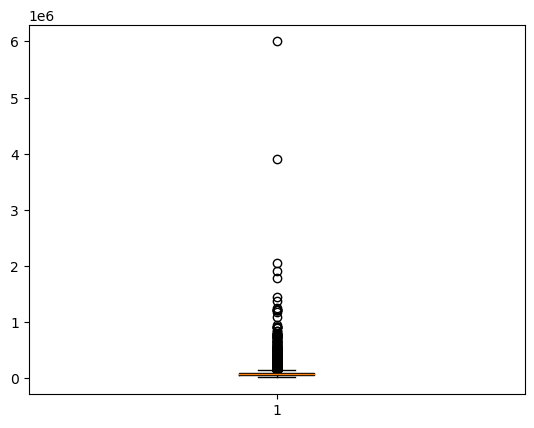

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64
__________________________________________________
verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: verification_status, dtype: int64
Error for verification_status
__________________________________________________
issue_d
Dec-11    2260
Nov-11    2223
Oct-11    2114
Sep-11    2063
Aug-11    1928
Jul-11    1870
Jun-11    1827
May-11    1689
Apr-11    1562
Mar-11    1443
Jan-11    1380
Feb-11    1297
Dec-10    1267
Oct-10    1132
Nov-10    1121
Jul-10    1119
Sep-10    1086
Aug-10    1078
Jun-10    1029
May-10     920
Apr-10     827
Mar-10     737
Feb-10     627
Nov-09     602
Dec-09     598
Jan-10     589
Oct-09     545
Sep-09     449
Aug-09     408
Jul-09     374
Jun-09     356
May-09     319
Apr-09     290
Mar-09     276
Feb-09

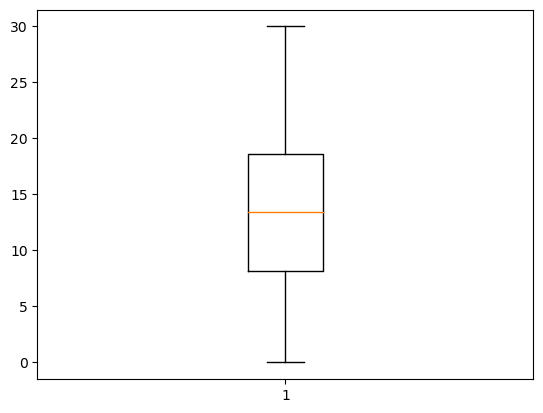

count    39717.000000
mean        13.315130
std          6.678594
min          0.000000
25%          8.170000
50%         13.400000
75%         18.600000
max         29.990000
Name: dti, dtype: float64
__________________________________________________
earliest_cr_line
Nov-98    370
Oct-99    366
Dec-98    348
Oct-00    346
Dec-97    329
         ... 
Feb-66      1
Dec-61      1
Oct-54      1
Jun-72      1
Oct-74      1
Name: earliest_cr_line, Length: 526, dtype: int64
Error for earliest_cr_line
__________________________________________________
inq_last_6mths
0    19300
1    10971
2     5812
3     3048
4      326
5      146
6       64
7       35
8       15
Name: inq_last_6mths, dtype: int64


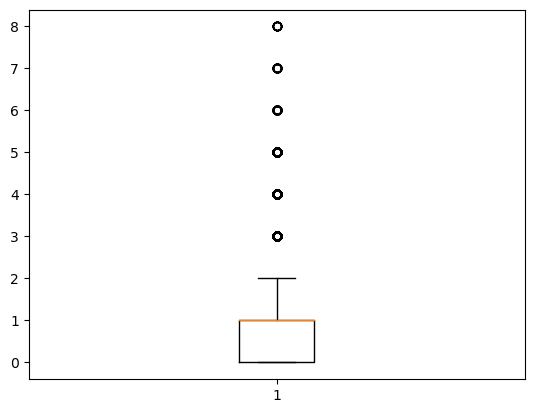

count    39717.000000
mean         0.869200
std          1.070219
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64
__________________________________________________
open_acc
7     4018
6     3946
8     3936
9     3718
10    3223
5     3183
11    2746
4     2343
12    2273
13    1911
3     1493
14    1487
15    1177
16     940
17     741
2      605
18     533
19     396
20     289
21     244
22     143
23      97
24      81
25      55
26      34
28      25
27      22
30      15
29      13
31       7
34       5
32       4
35       4
33       3
36       2
39       1
38       1
44       1
41       1
42       1
Name: open_acc, dtype: int64


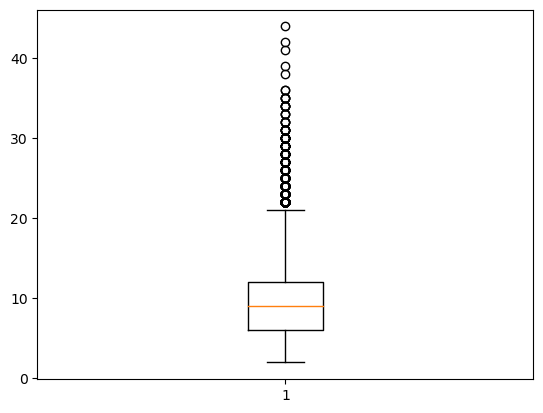

count    39717.000000
mean         9.294408
std          4.400282
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64
__________________________________________________
revol_bal
0        994
298       14
255       14
1         12
682       11
        ... 
21424      1
30747      1
23862      1
20197      1
85607      1
Name: revol_bal, Length: 21711, dtype: int64


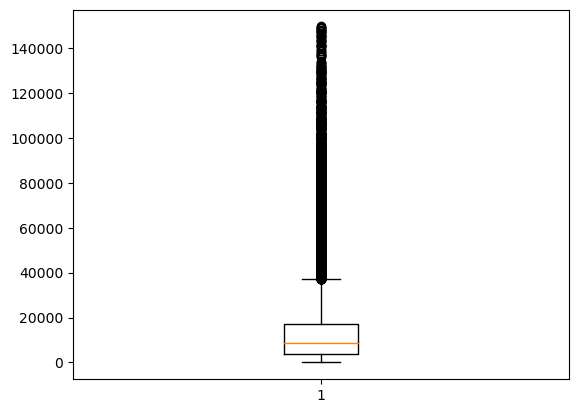

count     39717.000000
mean      13382.528086
std       15885.016641
min           0.000000
25%        3703.000000
50%        8850.000000
75%       17058.000000
max      149588.000000
Name: revol_bal, dtype: float64
__________________________________________________
revol_util
0%        977
0.20%      63
63%        62
40.70%     58
66.70%     58
         ... 
25.74%      1
47.36%      1
24.65%      1
10.61%      1
7.28%       1
Name: revol_util, Length: 1089, dtype: int64
Error for revol_util
__________________________________________________
total_acc
16    1471
15    1462
17    1457
14    1445
20    1428
      ... 
74       1
77       1
78       1
87       1
90       1
Name: total_acc, Length: 82, dtype: int64


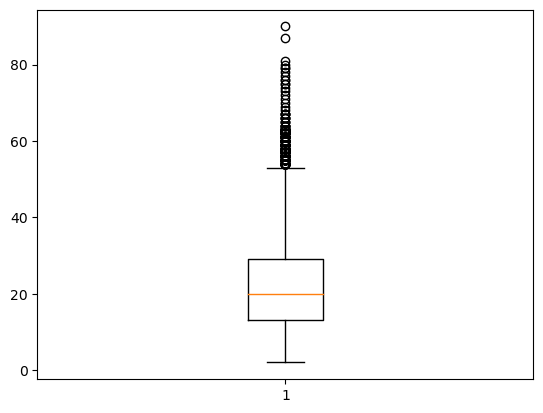

count    39717.000000
mean        22.088828
std         11.401709
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64
__________________________________________________
total_pymnt
11196.569430    26
0.000000        16
11784.232230    16
10956.775960    16
5478.387981     15
                ..
17768.430010     1
12794.806580     1
6193.803706      1
34797.769170     1
9195.263334      1
Name: total_pymnt, Length: 37850, dtype: int64


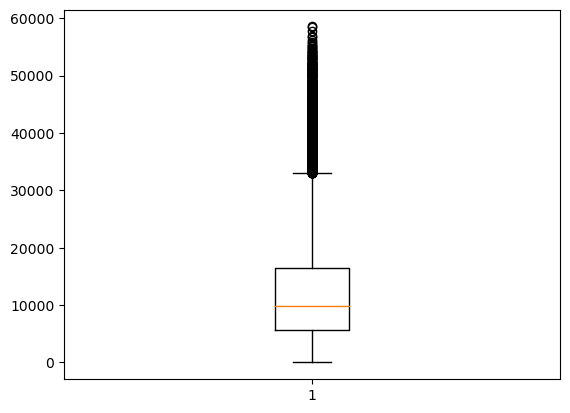

count    39717.000000
mean     12153.596544
std       9042.040766
min          0.000000
25%       5576.930000
50%       9899.640319
75%      16534.433040
max      58563.679930
Name: total_pymnt, dtype: float64
__________________________________________________
total_pymnt_inv
0.00        165
6514.52      16
5478.39      14
13148.14     14
11196.57     12
           ... 
17702.50      1
19026.06      1
7355.24       1
387.55        1
980.83        1
Name: total_pymnt_inv, Length: 37518, dtype: int64


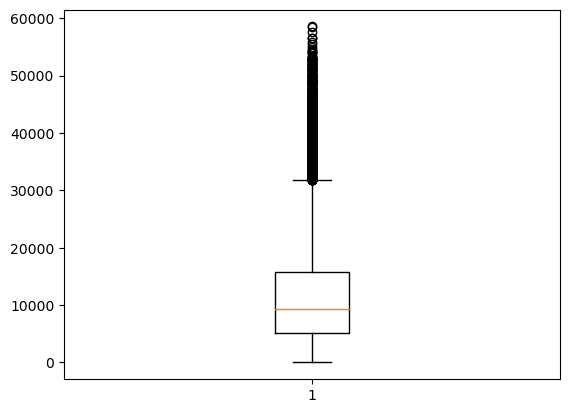

count    39717.000000
mean     11567.149118
std       8942.672613
min          0.000000
25%       5112.310000
50%       9287.150000
75%      15798.810000
max      58563.680000
Name: total_pymnt_inv, dtype: float64
__________________________________________________
total_rec_prncp
10000.00    2293
12000.00    1805
5000.00     1702
6000.00     1637
15000.00    1400
            ... 
1097.81        1
1410.30        1
6968.65        1
3477.49        1
16077.42       1
Name: total_rec_prncp, Length: 7976, dtype: int64


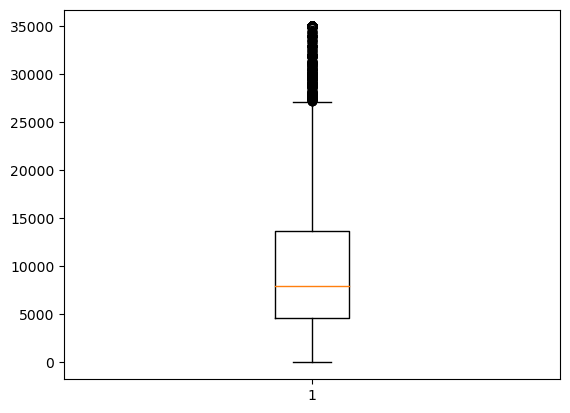

count    39717.000000
mean      9793.348813
std       7065.522127
min          0.000000
25%       4600.000000
50%       8000.000000
75%      13653.260000
max      35000.020000
Name: total_rec_prncp, dtype: float64
__________________________________________________
total_rec_int
0.00       71
1196.57    26
514.52     19
956.78     17
1784.23    17
           ..
494.53      1
1119.88     1
62.31       1
2656.10     1
1695.26     1
Name: total_rec_int, Length: 35148, dtype: int64


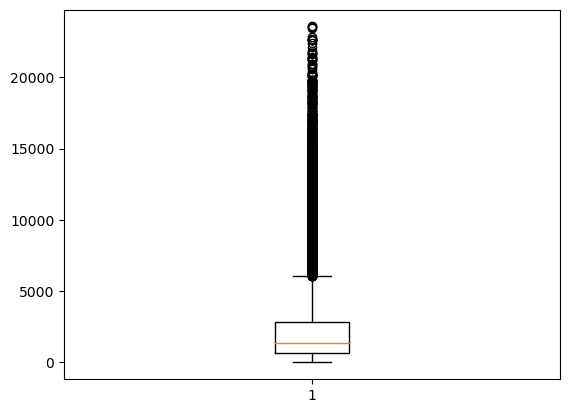

count    39717.000000
mean      2263.663172
std       2608.111964
min          0.000000
25%        662.180000
50%       1348.910000
75%       2833.400000
max      23563.680000
Name: total_rec_int, dtype: float64
__________________________________________________
total_rec_late_fee
0.000000     37671
15.000000      255
15.000000       58
30.000000       55
15.000000       47
             ...  
35.286832        1
15.000000        1
14.777500        1
14.967774        1
19.890000        1
Name: total_rec_late_fee, Length: 1356, dtype: int64


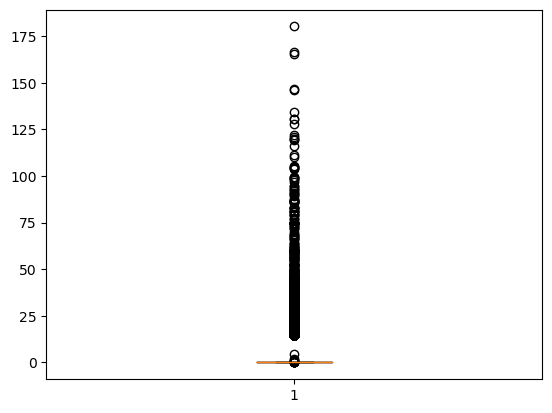

count    39717.000000
mean         1.363015
std          7.289979
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        180.200000
Name: total_rec_late_fee, dtype: float64
__________________________________________________
recoveries
0.00       35499
11.29          4
10.40          4
10.66          3
44.92          3
           ...  
764.69         1
653.08         1
1080.96        1
878.19         1
21.29          1
Name: recoveries, Length: 4040, dtype: int64


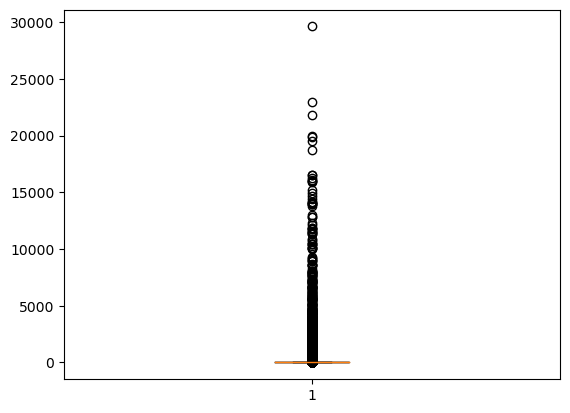

count    39717.000000
mean        95.221624
std        688.744771
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      29623.350000
Name: recoveries, dtype: float64
__________________________________________________
last_pymnt_d
May-16    1256
Mar-13    1026
Dec-14     945
May-13     907
Feb-13     869
          ... 
Jun-08      10
Nov-08      10
Mar-08       5
Jan-08       4
Feb-08       1
Name: last_pymnt_d, Length: 101, dtype: int64
Error for last_pymnt_d
__________________________________________________
last_pymnt_amnt
0.00       74
276.06     21
200.00     17
50.00      16
100.00     15
           ..
1763.87     1
172.27      1
889.67      1
150.73      1
256.59      1
Name: last_pymnt_amnt, Length: 34930, dtype: int64


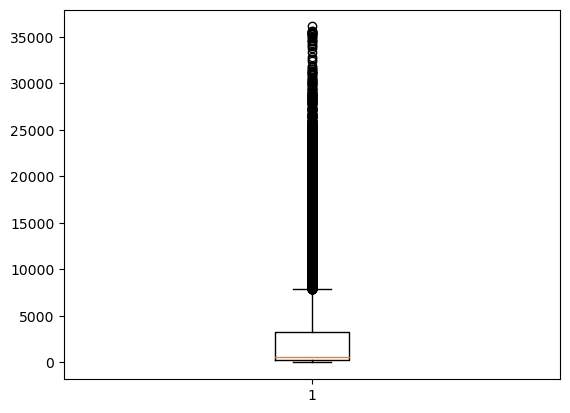

count    39717.000000
mean      2678.826162
std       4447.136012
min          0.000000
25%        218.680000
50%        546.140000
75%       3293.160000
max      36115.200000
Name: last_pymnt_amnt, dtype: float64
__________________________________________________
last_credit_pull_d
May-16    10308
Apr-16     2547
Mar-16     1123
Feb-13      843
Feb-16      736
          ...  
May-08        1
Jun-08        1
Jul-08        1
May-07        1
Jul-07        1
Name: last_credit_pull_d, Length: 106, dtype: int64
Error for last_credit_pull_d
__________________________________________________
tax_liens
0.0    39678
Name: tax_liens, dtype: int64


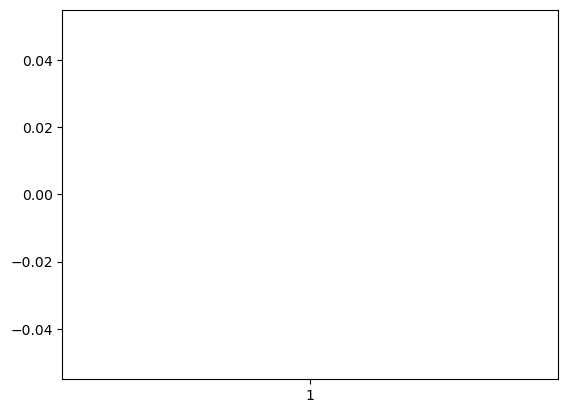

count    39678.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: tax_liens, dtype: float64
__________________________________________________


In [ ]:
columns = data1.columns
for item in col:
    print(colored(item, 'blue'))
    print(data1[item].value_counts())
    try: 
        plt.boxplot(data1[item])
        plt.show()
        print(data1[item].describe())

    except:
        print(colored(f'Error for {item}', 'red'))
    print("_" * 50)

In [ ]:
issue_d
url
purpose
title
zip_code
earliest_cr_line
revol_util
last_pymnt_d
last_credit_pull_d



In [ ]:
drop
single val

### Categorical Variables

- addr_state
- term
- verification_status
- loan_status


### Continuous Variables

- annual_inc - We can do buckets and use for as categorical




In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39717 non-null  int64  
 1   member_id            39717 non-null  int64  
 2   loan_amnt            39717 non-null  int64  
 3   funded_amnt          39717 non-null  int64  
 4   funded_amnt_inv      39717 non-null  float64
 5   term                 39717 non-null  object 
 6   int_rate             39717 non-null  object 
 7   installment          39717 non-null  float64
 8   grade                39717 non-null  object 
 9   sub_grade            39717 non-null  object 
 10  emp_title            37258 non-null  object 
 11  emp_length           38642 non-null  object 
 12  home_ownership       39717 non-null  object 
 13  annual_inc           39717 non-null  float64
 14  verification_status  39717 non-null  object 
 15  issue_d              39717 non-null 

### Why we are dropping 'collection_recovery_fee' column?
Because most of the values are 0 and remaining are outliers

In [ ]:
data1['collection_recovery_fee'].value_counts()

0.0000      35935
2.0000         12
1.2000         10
3.7100          9
1.8800          8
            ...  
3.7900          1
773.4900        1
272.8250        1
1.7697          1
0.2300          1
Name: collection_recovery_fee, Length: 2616, dtype: int64

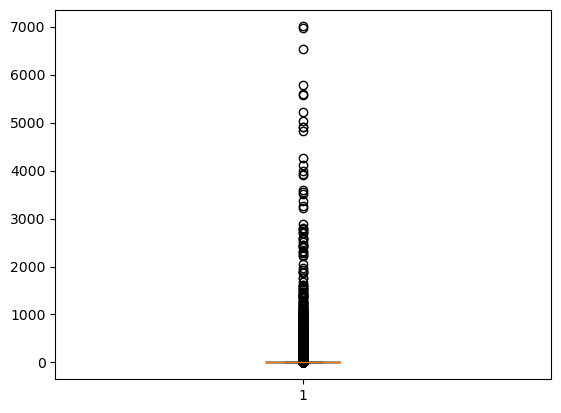

In [ ]:
plt.boxplot(data1['collection_recovery_fee'])
plt.show()

In [ ]:
data1['collection_recovery_fee'].describe()

count    39717.000000
mean        12.406112
std        148.671593
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       7002.190000
Name: collection_recovery_fee, dtype: float64

## Variables used 
- data - contains all the data from file 'loan.csv'
- empty_columns - The columns which are empty
- empty_data - This is empty data which contains 54 columns and empty/null rows
- data1 - contains data after dropping 54 empty columns